### Storing Horizontally flipped foreground objects

In [5]:
import os
from PIL import Image, ImageOps

pathfg = "C:/Users/divva/Desktop/New folder/cars/"
for count, filename in enumerate(os.listdir(pathfg)):    
        #Overlay bg and fg
        fg = Image.open(pathfg + filename)
        flip_fg = ImageOps.mirror(fg)
        flip_fg.save(pathfg + "flip_" + str(count) + ".png")

#### Renaming all foreground objects

In [6]:
for count, filename in enumerate(os.listdir(pathfg)):
    src = pathfg + filename
    dest = pathfg + "Car_" + str(count) + ".png"
    os.rename(src,dest)

#### Renaming all background objects to jpg for optimisation in space

In [17]:
pathbg = "C:/Users/divva/Desktop/New folder/new_bg/"

for cn,filename in enumerate(os.listdir(pathbg)):
    src = pathbg + filename
    dest = pathbg + "S_" + str(cn) + ".jpg"
    os.rename(src,dest)

### Creating Masks for all Foreground Objects

In [10]:
import os
import cv2

#create foreground image masks
pathfg = "C:/Users/divva/Desktop/New folder/cars/"
for filename in sorted(os.listdir(pathfg)):
    fn = filename.split('.')
    f = pathfg + filename
    print("Masking... ",f)
    img = cv2.imread(f, cv2.IMREAD_UNCHANGED)
    im = img[:,:,3]
    cv2.imwrite("C:/Users/divva/Desktop/New folder/fg_masks/" + fn[0] +"_mask.jpg", im)

Masking...  C:/Users/divva/Desktop/New folder/cars/Car_0.png
Masking...  C:/Users/divva/Desktop/New folder/cars/Car_1.png
Masking...  C:/Users/divva/Desktop/New folder/cars/Car_10.png
Masking...  C:/Users/divva/Desktop/New folder/cars/Car_100.png
Masking...  C:/Users/divva/Desktop/New folder/cars/Car_101.png
Masking...  C:/Users/divva/Desktop/New folder/cars/Car_102.png
Masking...  C:/Users/divva/Desktop/New folder/cars/Car_103.png
Masking...  C:/Users/divva/Desktop/New folder/cars/Car_104.png
Masking...  C:/Users/divva/Desktop/New folder/cars/Car_105.png
Masking...  C:/Users/divva/Desktop/New folder/cars/Car_106.png
Masking...  C:/Users/divva/Desktop/New folder/cars/Car_107.png
Masking...  C:/Users/divva/Desktop/New folder/cars/Car_108.png
Masking...  C:/Users/divva/Desktop/New folder/cars/Car_109.png
Masking...  C:/Users/divva/Desktop/New folder/cars/Car_11.png
Masking...  C:/Users/divva/Desktop/New folder/cars/Car_110.png
Masking...  C:/Users/divva/Desktop/New folder/cars/Car_111.pn

### Creating an Image out of a black patch of 2D array  
Important points:  
Creating an image with 3 RGB channels is not required when all we need is a black patch. Hence I have further tried to optimise the space occupancy by reducing it to a single channel, i.e., a single 2D array with pixel values as 0 to get a black background for masks

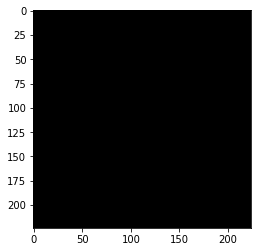

In [26]:
import matplotlib.pyplot as plt
mask_bg = np.zeros(shape = (224,224), dtype = np.uint8)
bgmask = Image.fromarray(mask_bg)
bgmask.save("D:/Deep Learning/MaskRCNN/black_bg.jpg")

plt.imshow(mask_bg, cmap='gray')

### Generating Overlayed Images and Respective Masks

In [34]:
import os
from PIL import Image, ImageOps
import random
import numpy as np

pathfg = "C:/Users/divva/Desktop/New folder/cars/"
pathbg = "C:/Users/divva/Desktop/New folder/new_bg/"
fg_mask_path = "C:/Users/divva/Desktop/New folder/fg_masks/"
maskbg = Image.open("D:/Deep Learning/MaskRCNN/black_bg.jpg")

location = [(9*a, 9*b) for a in range(20) for b in range(20)]
c = 0

def create_dataset(pathfg, pathbg, c, location):
    for count, filename in enumerate(os.listdir(pathfg)):    
        #Overlay bg and fg
        fg = Image.open(pathfg + filename)
        mask_fg = Image.open(fg_mask_path + (filename.split('.'))[0] + "_mask.jpg")
        
        for cn, fn in enumerate(os.listdir(pathbg)):
            backg = Image.open(pathbg + fn)

            for i in range(20):
                c+=1
                bg = backg.copy()
                mask_bg = maskbg.copy()
                
                loc = random.choice(location)
                bg.paste(fg, loc, fg)
                bg.save("D:/Deep Learning/MaskRCNN/bg_fg/P_" +str(c) + ".jpg")
                
                mask_bg.paste(mask_fg,loc,mask_fg)
                mask_bg.save("D:/Deep Learning/MaskRCNN/bg_fg_mask/mask_" + str(c) + ".jpg")
                
    print("No.of images created = ", c)
        
create_dataset(pathfg, pathbg, c, location)            


No.of images created =  460000


### Zipping Files in batches, recursively for depth map generation

In [ ]:
from zipfile import ZipFile

def BatchZipFile(dirName, zipfileName, rar_path, begin, end):
    #archv_path = os.path.join(rar_path, rarfilename)
    #with ZipFile(zipfileName, 'w') as zipObj:
    for folderNm, subfolders, filenames in os.walk(dirName):
        for filenm in filenames[begin:end]:
            filePath = os.path.join(folderNm, filenm)
            #zipObj.write(filePath)
            os.system('rar a <rar_path> <filePath>')
    
    
    
c = 1 
begin = 0
end = 1000
dirName = "D:/Deep Learning/MaskRCNN/bg_fg/"
rar_path = "D:/Deep Learning/MaskRCNN/Rar/"
while(c <= 460):
    zipfileName = "zipbatch" + str(c) + ".zip"
    rarfileName = "rarbatch" + str(c) + ".rar"
    BatchZipFile(dirName, zipfileName, rar_path, begin, end)
    begin = begin + 1000
    end = end + 1000
    c = c+1

### Finding Mean and Std. Deviation of Our Dataset  
**For Fg_bg images** 

In [2]:
import numpy as np
import os
import cv2
import timeit

In [33]:
# number of channels of the dataset image
CHANNEL_NUM = 3

def cal_mean_std(root):
    
    pixel_num = 0 # store all pixel number in the dataset
    channel_sum = np.zeros(CHANNEL_NUM)
    channel_sum_squared = np.zeros(CHANNEL_NUM)

    for idx, d in enumerate(os.listdir(root)):
        path = os.path.join(root,d)

        im = cv2.imread(path) # image in M*N*CHANNEL_NUM shape, channel in BGR order
        im = im/255.0
        pixel_num += (im.size/CHANNEL_NUM)
        channel_sum += np.sum(im, axis=(0, 1))
        channel_sum_squared += np.sum(np.square(im), axis=(0, 1))

    bgr_mean = channel_sum / pixel_num
    bgr_std = np.sqrt(channel_sum_squared / pixel_num - np.square(bgr_mean))
    
    # change the format from bgr to rgb
    rgb_mean = list(bgr_mean)[::-1]
    rgb_std = list(bgr_std)[::-1]
    
    return rgb_mean, rgb_std

# The script assumes that under train_root, there are separate directories for each class
# of training images.
train_root = "D:/Deep Learning/MaskRCNN/bg_fg/"
start = timeit.default_timer()
mean, std = cal_mean_std(train_root)
end = timeit.default_timer()
print("elapsed time: {}".format(end-start))
print("mean:{}\nstd:{}".format(mean, std))

elapsed time: 1639.886362199999
mean:[0.40456055804985874, 0.3983824357134671, 0.3925343274986984]
std:[0.2599649396912192, 0.2609780929820059, 0.27395228266780175]


**For Masks of fg_bg**

In [16]:
# number of channels of the dataset mask image
CHANNEL_NUM = 3

def cal_mean_std(root):
    
    pixel_num = 0 # store all pixel number in the dataset
    channel_sum = np.zeros(CHANNEL_NUM)
    channel_sum_squared = np.zeros(CHANNEL_NUM)

    for idx, d in enumerate(os.listdir(root)):
        path = os.path.join(root,d)

        im = cv2.imread(path) # image in M*N*CHANNEL_NUM shape, channel in BGR order
        im = im/255.0
        pixel_num += (im.size/CHANNEL_NUM)
        channel_sum += np.sum(im, axis=(0,1))
        channel_sum_squared += np.sum(np.square(im), axis=(0, 1))

    bgr_mean = channel_sum / pixel_num
    bgr_std = np.sqrt(channel_sum_squared / pixel_num - np.square(bgr_mean))
    
    # change the format from bgr to rgb
    rgb_mean = list(bgr_mean)[::-1]
    rgb_std = list(bgr_std)[::-1]
    
    return rgb_mean, rgb_std

# The script assumes that under train_root, there are separate directories for each class
# of training images.
train_root = "C:/Users/divva/Desktop/New folder/fg_masks/"
start = timeit.default_timer()
mean, std = cal_mean_std(train_root)
end = timeit.default_timer()
print("elapsed time: {}".format(end-start))
print("Foreground Mask mean:{}\nstd:{}".format(mean, std))

elapsed time: 0.19424100000014732
Depth_Maps mean:[0.4901594366127988, 0.4901594366127988, 0.4901594366127988]
std:[0.48846756739825214, 0.48846756739825214, 0.48846756739825214]


In [17]:
train_root = "D:/Deep Learning/MaskRCNN/bg_fg_mask/"
start = timeit.default_timer()
mean, std = cal_mean_std(train_root)
end = timeit.default_timer()
print("elapsed time: {}".format(end-start))
print("Depth_Maps mean:{}\nstd:{}".format(mean, std))

elapsed time: 1348.040793799999
Depth_Maps mean:[0.07221486453923726, 0.07221486453923726, 0.07221486453923726]
std:[0.2556922185275919, 0.2556922185275919, 0.2556922185275919]
